### <h2 style="font-size: 40px;">Прогноз цены автомобилей с пробегом</h2>

#### Техническое задание

Разработать модель машинного обучения для определения рыночной стоимости подержанных автомобилей на основе их технических характеристик и комплектаций. Модель будет использоваться в мобильном или веб-приложении, помогающем пользователям оценить стоимость своего автомобиля.


1. Ключевые требования:
    - Точность предсказаний – модель должна максимально точно предсказывать рыночную цену.
    - Скорость обучения – время обучения модели не должно быть чрезмерно большим.
    - Скорость предсказания – модель должна быстро выдавать результат, чтобы обеспечить удобство пользователей.


2. Данные:
    - Входные данные включают информацию о характеристиках автомобилей и их исторические цены.


3. Цель:
    - Построить модель, оптимально балансирующую между точностью и производительностью для интеграции в сервис оценки автомобилей.

#### Описание данных

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро)

### Загрузка данных

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import optuna

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

from optuna.integration import OptunaSearchCV
from optuna import distributions

In [220]:
# Функция для загрузки датасета 
def get_dataframe(path_global, path_local, dates_cols, sep=','):
    if os.path.exists(path_global):
        path = path_global
    elif os.path.exists(path_local):
        path = path_local
    else:
        print('Неправильный путь к файлу')
        return None
    
    df = pd.read_csv(path, sep=sep, parse_dates=dates_cols)
    display(df.head())

    print('Количество пропусков:')
    display(round(df.isna().mean() * 100, 2).sort_values(ascending=False))

    df.info()
    return df

In [221]:
path0 = '/datasets/autos.csv'
path1 = './datasets/autos.csv'
dates_cols = ['DateCrawled', 'DateCreated', 'LastSeen']

data_auto = get_dataframe(path0, path1, dates_cols)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Количество пропусков:


Repaired             20.08
VehicleType          10.58
FuelType              9.28
Gearbox               5.60
Model                 5.56
DateCrawled           0.00
Price                 0.00
RegistrationYear      0.00
Power                 0.00
Kilometer             0.00
RegistrationMonth     0.00
Brand                 0.00
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

#### Вывод загрузки данных

1. В таблице **`data_auto`** имеются пропуски:

| Признак          | % пропусков|
|------------------|------------|
| Repaired         | 20.08      |
| VehicleType      | 10.58      |
| FuelType         | 9.28       |
| Gearbox          | 5.60       |
| Model            | 5.56       |


2. Неправильные типы данных:

Следует обьединить `RegistrationYear` и `RegistrationMonth` в один признак под названием `RegistrationDate` и перевести в тип datetime64.

### Предобработка данных

#### Поиск дубликатов

In [222]:
display(data_auto[data_auto.duplicated(keep=False)])
data_auto = data_auto.drop_duplicates(keep='first').reset_index(drop=True)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


В датасете были обнаружены 4 полных дубликата, они были удалены.

#### Создание даты регистрации

In [223]:
data_auto['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

В данных присутсвтуют некорректные года регистрации пользователей.

In [224]:
data_auto['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Нумерация месяца регистрации пользователя начинается с 0.

In [225]:
data_auto['RegistrationDate'] = pd.to_datetime(
    data_auto['RegistrationYear'].astype(str) + '-' + 
    (data_auto['RegistrationMonth'] + 1).astype(str) + '-01',  # +1 к месяцу
    format='%Y-%m-%d',
    errors='coerce'
)

data_auto.drop(['RegistrationYear', 'RegistrationMonth'], axis=1, inplace=True)
data_auto.head()

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,RegistrationDate
0,2016-03-24 11:52:17,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-06-01
2,2016-03-14 12:52:21,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,2004-09-01
3,2016-03-17 16:54:04,1500,small,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-07-01
4,2016-03-31 17:25:20,3600,small,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-08-01


В датасет была добавлена дата регистрации. Используя параметр *errors='coerce'* были упущены некорректные года регистрации.

In [226]:
data_auto.query('RegistrationDate < 2016 and RegistrationDate > 1980', inplace=True)

Данные по дате регистрации были ограничены периодом с 1980 по 2016 год.

#### Удаление и замена пропусков

In [227]:
for clm in data_auto.columns:
    if data_auto[clm].nunique() <= 25:
        print(f'{clm}: {data_auto[clm].unique()}')

VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox: ['manual' 'auto' nan]
Kilometer: [150000 125000  90000  40000  30000  70000 100000  60000   5000  20000
  80000  50000  10000]
FuelType: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
Repaired: [nan 'yes' 'no']
NumberOfPictures: [0]


Признак `NumberOfPictures` имеет значение значение 0 на всех наблюдениях. Такой признак является неиформативным и его следует удалить. \
В датасете отсутсвтуют неправильные значения признаков.

In [228]:
data_auto.drop('NumberOfPictures', axis=1, inplace=True)

data_auto.head()

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,RegistrationDate
0,2016-03-24 11:52:17,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,2011-06-01
2,2016-03-14 12:52:21,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46,2004-09-01
3,2016-03-17 16:54:04,1500,small,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,2001-07-01
4,2016-03-31 17:25:20,3600,small,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,2008-08-01


Столбец `NumberOfPictures` был удален из датасета.

In [229]:
len_data = data_auto.shape[0]

data_auto.dropna(subset=['VehicleType', 'Model'], inplace=True)
print(f'Количество удаленных данных: {round(100 - data_auto.shape[0] / (len_data/100), 2)}%')

Количество удаленных данных: 7.88%


Признаки `VehicleType` и `Model` имеют менее 5% пропусков. Такое малое количество пропусков было удалено из датасета.

In [230]:
categorical_features = ['Repaired', 'FuelType', 'Gearbox']

cat_pipe = Pipeline(
    [
        ('simple_imputer_cat',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)

In [231]:
preliminary_preprocessor = ColumnTransformer(
    [
        ('fill_na_cat', cat_pipe, categorical_features)
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [232]:
lst_columns_train = data_auto.columns.tolist() # Порядок столбцов прошлой таблицы

data_auto = (preliminary_preprocessor.fit_transform(data_auto.drop('Price', axis=1))
                          .join(data_auto['Price']))[lst_columns_train]

Строки содержащие пропуски в столбцах `VehicleType`, `Model`, `RegistrationDate` были удалены, утерено 20% данных. \
Пропуски признаков `Repaired`, `FuelType`, `Gearbox` были заменены на самые частовстречаемые значения категорий.

### Исследовательский анализ

In [233]:
def plt_distribution(df):
    plt.figure(figsize=(22, 18))
    cols_num = df.select_dtypes(include='number').columns
    cols_cat = data_auto.select_dtypes(exclude='number').columns

    i = 1
    # Отрисовка распределений количественных фич
    for clm in cols_num:
        plt.subplot(4, 2, i)
        if df[clm].nunique() >= 20:
            ax = sns.histplot(data=df, x=clm, stat="density")
            sns.kdeplot(data=df, x=clm, bw_method=0.07, color="red")
        else:
            ax = sns.countplot(data=df, x=clm, color='#1F77B4') 
        ax.set_ylabel('частота')
        i += 1

    # Графики категориальных
    for clm in cols_cat:
        if df[clm].nunique() <= 20:
            plt.subplot(4, 2, i)
            ax = sns.countplot(data=df, x=clm, color='#1F77B4')
            ax.set_ylabel('частота')
            i += 1

In [234]:
data_auto.describe()

,Price,Power,Kilometer,PostalCode
count,279735.000000,279735.000000,279735.000000,279735.000000
mean,4681.841557,115.015543,128726.294529,51001.356545
std,4579.891801,175.294560,36514.000698,25756.233768
min,0.000000,0.000000,5000.000000,1067.000000
25%,1250.000000,75.000000,125000.000000,30823.000000
50%,2999.000000,107.000000,150000.000000,49835.000000
75%,6800.000000,144.000000,150000.000000,71640.000000
max,20000.000000,20000.000000,150000.000000,99998.000000


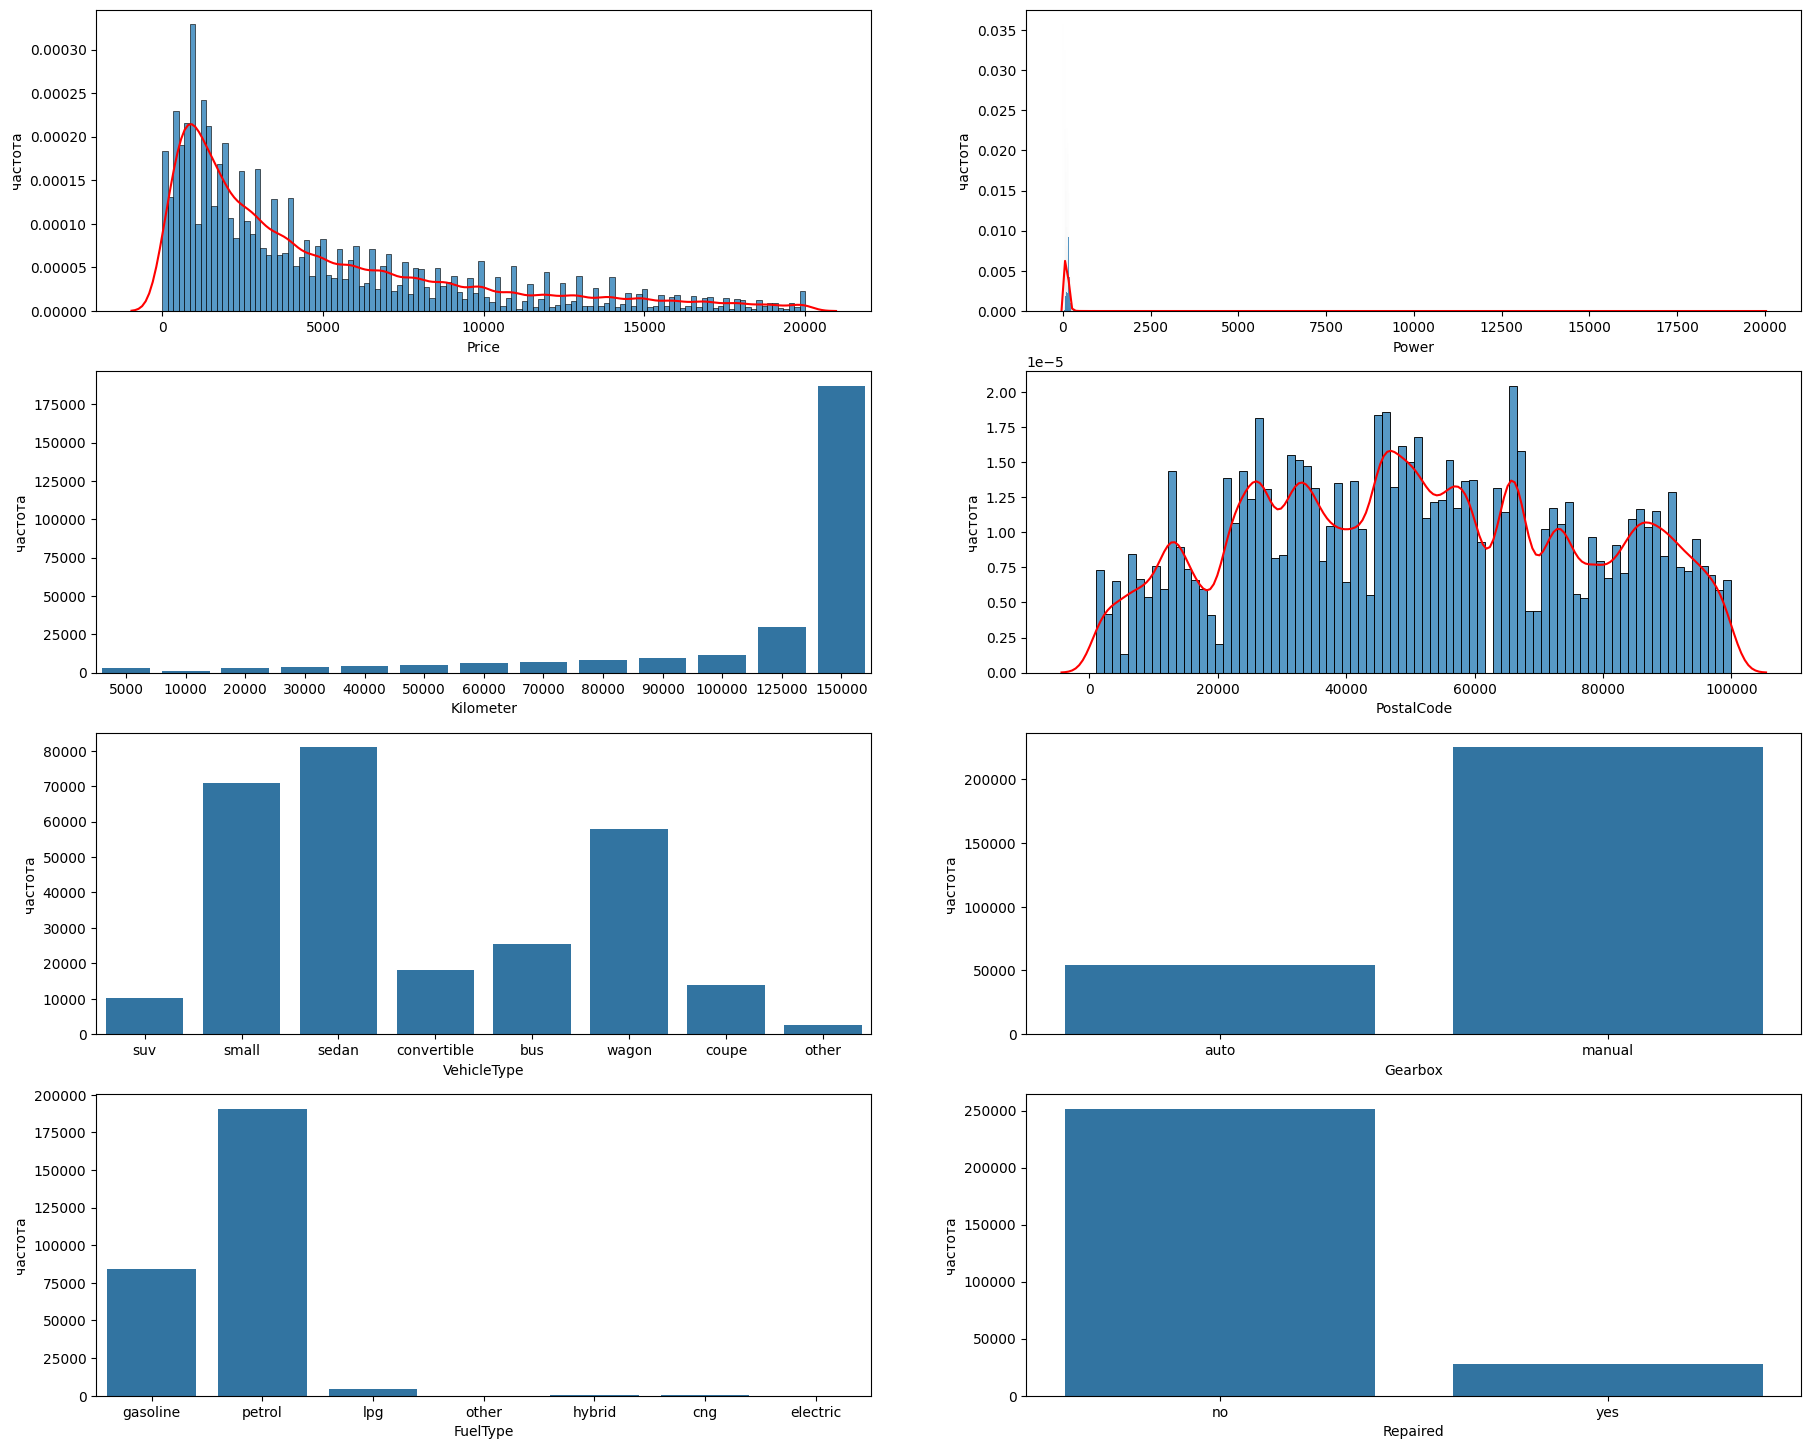

In [235]:
plt_distribution(data_auto)

В данных наблюдаются аномалии и выбросы:
1. `Price` имеет нулевые значения
2. `Power` имеет и нулевые и экстремально большие значения
3. `FuelType` имеет малое количество наблюдений на категориях 'other', 'hybrid', 'cng', 'electric'

In [236]:
data_auto.query('Price > 400', inplace=True)

Нулевые значения стоимости были убраны фильтром. Остались наблюдения, у которых стоимость более 400.

In [239]:
data_auto.query('Power < 250 and Power > 50', inplace=True)

Мощность была ограничена отрезком от 50 до 250 лошадиных сил.

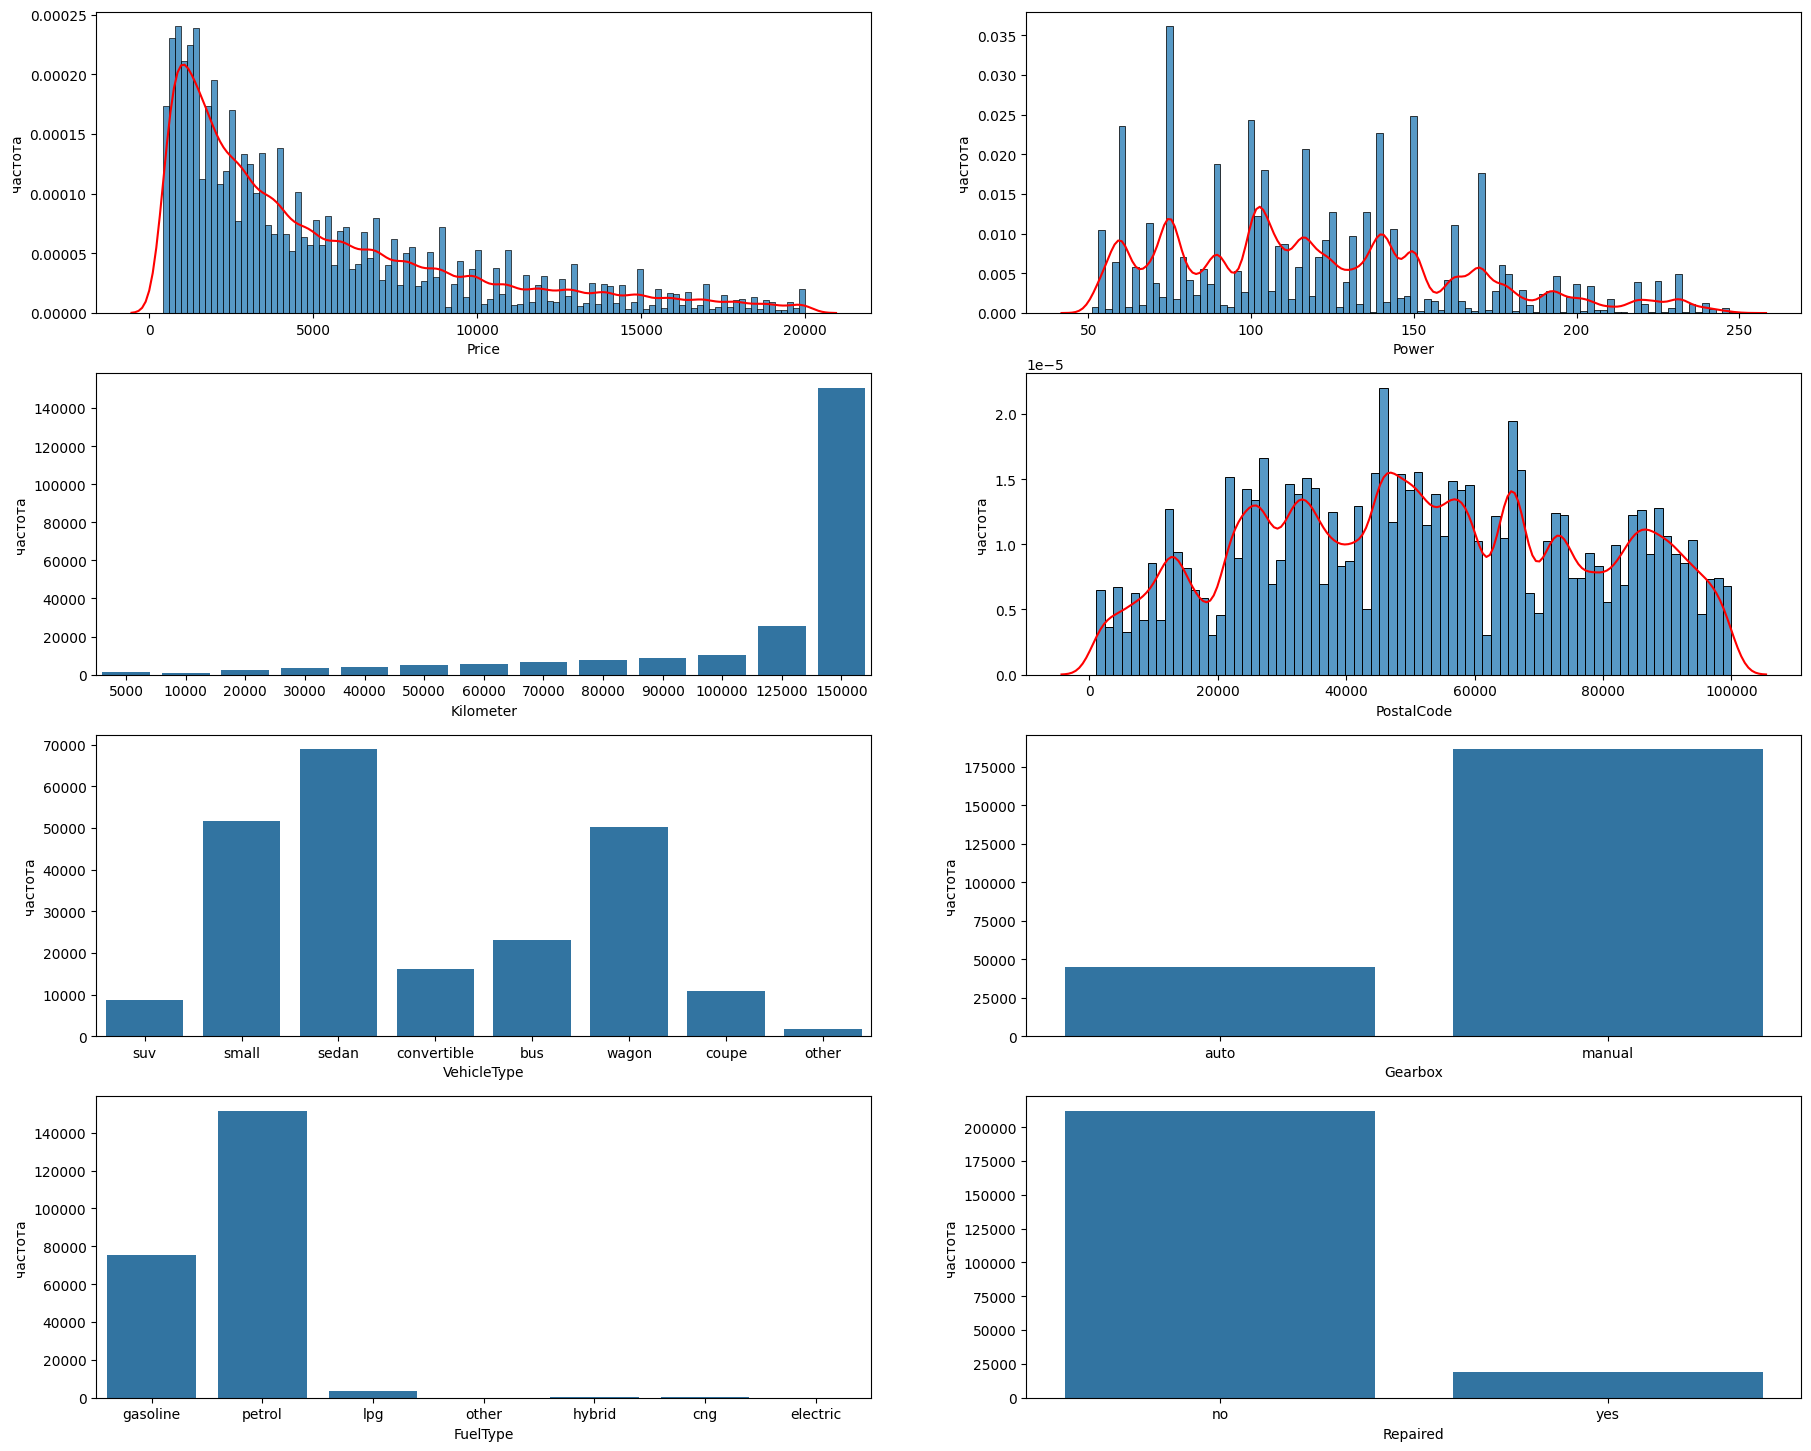

In [240]:
plt_distribution(data_auto)